In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
 N = 100
 L = 1000
 T = 20

 x = np.empty((N,L),np.float32)
 x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T ,N).reshape(N,1)
 y = np.sin(x/1.0/T).astype(np.float32)
 

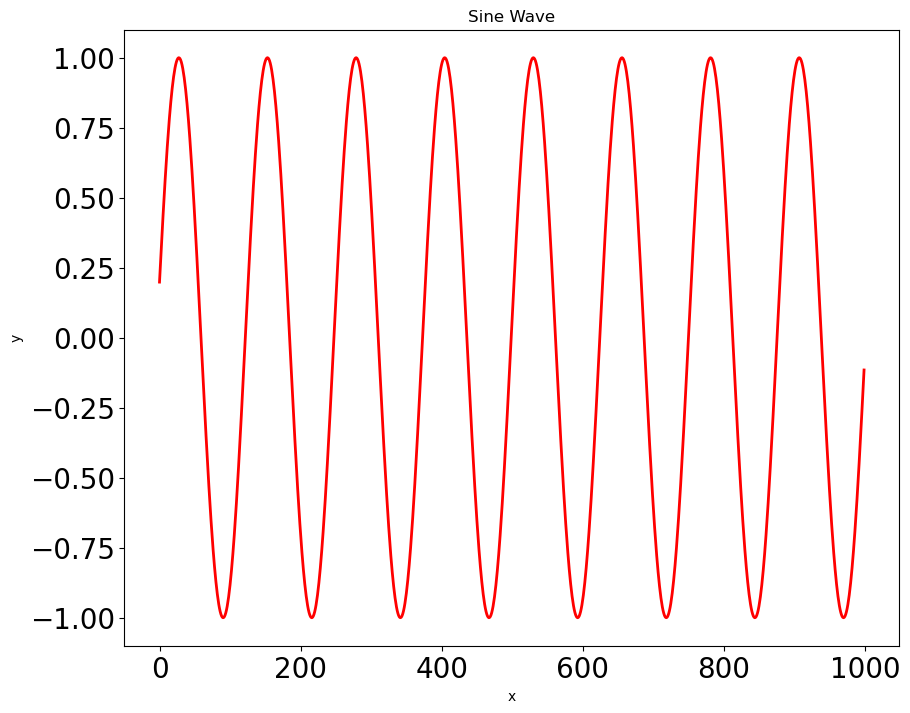

In [3]:
plt.figure(figsize=(10,8))
plt.title("Sine Wave")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(np.arange(x.shape[1]),y[0,:],'r',linewidth=2.0)
plt.show()


In [5]:
class LSTMPredictor(nn.Module):
  def __init__(self,n_hidden=51):
    super(LSTMPredictor,self).__init__()
    self.n_hidden = n_hidden
    # lstm1 , lstm2 , linear
    self.lstm1 = nn.LSTMCell(1,self.n_hidden)
    self.lstm2 = nn.LSTMCell(self.n_hidden , self.n_hidden)
    self.linear = nn.Linear(self.n_hidden,1)
  
  def forward(self,x,future=0):
    outputs = []
    n_samples = x.size(0)

    h_t = torch.zeros(n_samples , self.n_hidden,dtype=torch.float32)
    c_t = torch.zeros(n_samples , self.n_hidden,dtype=torch.float32)

    h_t2 = torch.zeros(n_samples , self.n_hidden,dtype=torch.float32)
    c_t2 = torch.zeros(n_samples , self.n_hidden,dtype=torch.float32)

    for input_t in x.split(1,dim=1):
      #N,1
      h_t , c_t = self.lstm1(input_t,(h_t,c_t))
      h_t2 , c_t2 = self.lstm2(h_t,(h_t2,c_t2))
      output=self.linear(h_t2)
      outputs.append(output)
    
    for i in range(future):
      h_t , c_t = self.lstm1(output,(h_t,c_t))
      h_t2 , c_t2 = self.lstm2(h_t,(h_t2,c_t2))
      output = self.linear(h_t2)
      outputs.append(output)
    outputs = torch.cat(outputs,dim=1)
    return outputs
  


    
if __name__=="__main__":
  # y = 100,1000
  train_input = torch.from_numpy(y[3:,:-1]) #97,999
  train_target = torch.from_numpy(y[3:,1:]) #97,999
  test_input = torch.from_numpy(y[3:,:-1]) #3,999
  test_target = torch.from_numpy(y[3:,1:]) #3,999

  model = LSTMPredictor()
  criterion = nn.MSELoss()

  optimizer = optim.LBFGS(model.parameters(),lr=0.8)

  n_steps = 20
  for i in range(n_steps):
    print("Step",i)

    def closure():
      optimizer.zero_grad()
      out = model(train_input)
      loss = criterion(out,train_target)
      print("loss",loss.item())
      loss.backward()
      return loss
    optimizer.step(closure)

    with torch.no_grad():
      future=1000
      pred = model(test_input,future=future)
      loss = criterion(pred[:,:-future],test_target)
      print("test loss",loss.item())
      y = pred.detach().numpy()

    plt.figure(figsize=(12,6))
    plt.title(f"Step {i+1}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    n = train_input.shape[1] #999

    def draw(y_i,color):
      plt.plot(np.arange(n),y_i[:n],color,linewidth=2.0)
      plt.plot(np.arange(n,n+future),y_i[n:],color+":",linewidth=2.0)
    draw(y[0],'r')
    draw(y[1],'b')
    draw(y[2],'g')

    plt.savefig("predict%d.pdf"%i)
    plt.close()












  





Step 0
loss 0.5494018197059631
loss 0.5448601245880127
loss 0.5141215920448303
loss 0.4679393172264099
loss 0.315815269947052
loss 0.13319329917430878
loss 0.1541091799736023
loss 0.04447980225086212
loss 0.029928043484687805
loss 0.028500044718384743
loss 0.027805158868432045
loss 0.026606133207678795
loss 0.02426913194358349
loss 0.019863609224557877
loss 0.011548644863069057
loss 0.008192306384444237
loss 0.006900966167449951
loss 0.00566125987097621
loss 0.003957502543926239
loss 0.0025177053175866604
test loss 0.001312477164901793
Step 1
loss 0.001312477164901793
loss 0.0010720579884946346
loss 0.001045018550939858
loss 0.0009947901125997305
loss 0.0008719445904716849
loss 0.0007160048699006438
loss 0.0006133598508313298
loss 0.0005669957026839256
loss 0.0005343529628589749
loss 0.0005266103544272482
loss 0.0005221713799983263
loss 0.0005172208184376359
loss 0.0004992152098566294
loss 0.0004648250760510564
loss 0.0004097770433872938
loss 0.00034451665123924613
loss 0.0002526443859